# Data Collection

> In this notebook, my program will determine what coins to buy based on who you follow.

---

## Imports

In [2]:
import pandas as pd
import numpy as np
import time
import datetime
from time import sleep
import random
import json
import re
import matplotlib.pyplot as plt

In [3]:
import snscrape.modules.twitter as sntwitter
import tweepy

In [4]:
from googletrans import Translator
import googletrans
import langid

In [5]:
from pycoingecko import CoinGeckoAPI

In [6]:
import spacy
from spacytextblob.spacytextblob import SpacyTextBlob

nlp = spacy.load('en_core_web_sm')
nlp.add_pipe("spacytextblob")

In [7]:
import re
import nltk
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.tokenize import RegexpTokenizer
from nltk.stem import WordNetLemmatizer,PorterStemmer
from nltk.corpus import stopwords
lemmatizer = WordNetLemmatizer()
stemmer = PorterStemmer() 

[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\tu\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\tu\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [8]:
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

# Testing out APIs & Connections

In [9]:
# get coin data from coingecko and put into dataframe
cg = CoinGeckoAPI()

In [10]:
#Installation / Access to Twitter account
api_key = 'dgqNoUpTRqlb3IIouS3e5XtwA'
api_secret = 'QwqjQKaTcOqBayJfo0nCxzJskKVRKfpz6TMqdrjfWapDLcDZxn'
bearer = 'AAAAAAAAAAAAAAAAAAAAAOyqmgEAAAAALPts2%2F6ViUSpOTZzT7hOQz1ai4E%3DzHpq5nOJU2nCgyS8sHYejwWLaJfnXjbSMRjJLCoRqrwPT72IZU'
client_id = 'U0t5XzFmMV8yME1Iby1wTnROdDA6MTpjaQ'
client_secret = 'PueWEQpZjig1X19teUd3qykdbVMhkjNvI7BJMbwc9k34UXoiOj'
access_token = '1443382185000570882-XesEvzWfQtQe5IkhvHTKJjjBYEqN3H'
access_token_secret = 'X7G6RBUWvYWA8tGLS58eRR64pFwfYIXshqnV5kyCipdrv'
USER_ID = '1443382185000570882'

In [11]:
authenticator = tweepy.OAuthHandler(api_key, api_secret)
authenticator.set_access_token(access_token, access_token_secret)
twitter = tweepy.API(authenticator, wait_on_rate_limit=True)

# Functions

#### Scrape Following

In [12]:
def scrape_following(user):
    following = []
    for user in tweepy.Cursor(twitter.get_friends, screen_name=user).items():
        following.append(user.screen_name)
    return following

> This function scrapes the followings aka 'friends' of a specific user and returns a list

#### Scrape Tweets from Following List

In [13]:
# Scrapes tweets from list of following

def scrape_tweets_list(users, limit, days):
    
    today = datetime.date.today()
    days_ago = today - datetime.timedelta(days=days)
    
    tweets = []
     
    for user in users:
        query = ' -giveaway, -winner (from:' + user + ') since:' + str(days_ago)
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
            if i>limit:
                break
            tweets.append([tweet.id,tweet.date,tweet.user.username,tweet.rawContent,
                    tweet.hashtags,tweet.likeCount, tweet.user.followersCount])
    data = pd.DataFrame(tweets,columns=['id','date','username','Content','hashtags','Likes','followers']) 
    return data

> This function scrapes tweets from each of your following list. This function takes in 3 arguments: users, limit, and days. 

- Users = following list
- Limit = how many tweets you want scraped per user
- Days = How far back do you want to start the scrape?

#### Clean Tweets

In [14]:
# Function that cleans tweets, removing unneccessary jargon
def clean_tweet(twt):
    """ 
    - remove words that begin with @
    - remove words that begin with https://
    - remove hashtags
    - remove emojis
    """
    twt = re.sub('#[A-Za-z0-9]+', '', twt)
    twt = re.sub('\\n', '', twt)
    twt = re.sub('https?:\/\/\S+', '', twt)
    
    return twt

> This function cleans each row by removing any hashtags, new line characters, links

#### Find Coins

In [15]:
def find_coins(twt):
    """
    - finds all words involving dollar signs
    """
    twt = re.findall(r'\$\w+', twt)
    return twt

> This function finds all coins within each tweet

In [16]:
def find_coin_nocashtag(twt, coins):
    
    basket = set(coins)
    words = re.compile('\w+')

    for match in words.finditer(twt):
        coin = match.group()
        if coin in basket:
            return coin

> This function finds all coins that don't have cashtags within each tweet given the coin list

#### Clean Coins

In [17]:
def clean_coins(coins):
    # input each row
    # create a loop that goes through each row
    
    # Loop through each row
    coin_list = []
    disallowed_characters = "._!,"
    
    # Loop through each row
    for tag in coins:
        # Iterate through each row
        for x in tag:
            
            # Identify any weird coins and fix em'
            for character in disallowed_characters:
                x = x.replace(character, "")
                
            # If any coins have just dollar signs and no texts
            if len(x) == 1:
                None
            
            # If the second digit is a number, take it out
            elif x[1].isdigit() == False:
                coin_list.append(x)
            
            # Append all else's to a list
            else:
                None
                
    # Turn that list into a dataframe
    new_coin_list = pd.DataFrame(coin_list, columns = ['coins'])
    
    # Organize it and return
    res = new_coin_list['coins'].value_counts()\
                 .to_frame('count').rename_axis('coin')\
                 .reset_index()
    
    return res   

> This function is specific for the 'Coin' column. It is intended to clean up the column by removing any unnessecary spaces or special characters and then identify the count each coin which is then stored in a separate database.

#### Coin Symbols

In [18]:
def coin_symbols(symbols):
    # ($btc, OR $eth, OR $geth, OR $ampl, OR $sushi) 
    # convert dataframe into format above
    x = ", OR ".join(symbols)
    x = '(' + x + ')'
    return x

> This function transforms the cleaned-coin database into a string format to use for a future query.

#### Scrape Users Tweets from List of Coins

In [19]:
# Scrapes tweets from list of following WITH COINS

def scrape_tweets_list_coins(users, limit, coins, days):
    
    today = datetime.date.today()
    days_ago = today - datetime.timedelta(days=days)
    
    tweets = []
    
    for user in users:
        
        query = coins + ' -giveaway, -winner (from:' + user + ') since:' + str(days_ago) + ' -filter:links'
        
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
            if i>limit:
                break
            tweets.append([tweet.id,tweet.date,tweet.user.username,tweet.rawContent,
                    tweet.hashtags,tweet.likeCount])
    data = pd.DataFrame(tweets,columns=['id','date','username','Content','hashtags','Likes']) 
    return data

> This function scrapes tweets involving specific coin list from following list. This function takes in 3 arguments:
- Users: List of following
- Limit: How many tweets you want to scrape per user
- Coins: List of coins
- Days: How many days back do you want to start the scrape

## Scraping Entire Twitter

### Scrape Entire Twitter with Coin List (any language)

In [20]:
# Scrapes tweets from entire twitter with coins any language

def scrape_entire_tweets_list_coins_anylang(limit, coin_list, days):
    
    today = datetime.date.today()
    days_ago = today - datetime.timedelta(days=days)
    
    tweets = []
    
    for coin in coin_list['coin'][:20].tolist():
        query = '(' + coin + ')' + ' -giveaway, -winner min_faves:2 since:' + str(days_ago) + ' -filter:links'
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
            if i>limit:
                break
            tweets.append([tweet.id,tweet.date,tweet.user.username,tweet.rawContent,
                    tweet.hashtags,tweet.likeCount,tweet.user.followersCount])
    data = pd.DataFrame(tweets,columns=['id','date','username','Content','hashtags','Likes','followers']) 
    return data

> This function scrapes entire twitter involving specific coin list. This function takes in 3 arguments:
- Limit: How many tweets you want to scrape per coin
- Coins: List of coins
- Days: How many days back do you want to start the scrape

### Scrape Entire Twitter Tweets from List of Coins with Specific Language

In [21]:
# Scrapes tweets from entire twitter with coins specific language

def scrape_entire_tweets_list_coins(limit, coin_list, days, language):
    
    today = datetime.date.today()
    days_ago = today - datetime.timedelta(days=days)
    
    tweets = []
    
    for coin in coin_list['coin'][:20].tolist():
        query = '(' + coin + ')' + ' -giveaway, -winner lang:' + language + ' since:' + str(days_ago) + ' -filter:links'
        for i,tweet in enumerate(sntwitter.TwitterSearchScraper(query).get_items()):
            if i>limit:
                break
            tweets.append([tweet.id,tweet.date,tweet.user.username,tweet.rawContent,
                    tweet.hashtags,tweet.likeCount,tweet.user.followersCount])
    data = pd.DataFrame(tweets,columns=['id','date','username','Content','hashtags','Likes','followers']) 
    return data

> This function scrapes tweets in a specific language from entire twitter involving specific coin list. This function takes in 4 arguments:
- Limit: How many tweets you want to scrape per coin
- Coins: List of coins
- Days: How many days back do you want to start the scrape
- Language: What language are you looking to scrape

#### Create Language Column

In [22]:
def lang_column(df):
    df['Language'] = None
    for i in range(0, len(df['Content'])):
        df['Language'][i] = langid.classify(df['Content'][i])[0]    
    return df

> This function identifies which language specific tweets are in.

#### Translated Tweets to English

In [23]:
def trans_column(clean_df):
    translator = Translator()
    clean_df['translated'] = clean_df['cleaned_tweets'].apply(translator.translate, 
                                                                                  src='auto', 
                                                                                  dest='en').apply(getattr, 
                                                                                                   args=('text',))
    return clean_df

> This function identifies which tweets aren't english, and automatically translates them into english into a new column called Translated

#### Create Target Column

In [87]:
def create_target(df):
    df['tomorrow'] = df['close'].shift(-1)
    df['target'] = (df['tomorrow'] > df['close']).astype(int)
    return df

#### Preprocess Tweets

> This function preprocesses sentences (or tweets in this case) with/without stemming/lemmatizing. This function takes 4 arguments:
- Sentence: The sentence you want to perform preprocessing on
- Stopwords: List of additional stopwords you want to take out
- Stemming: True/False
- Lemmatizing: True/False

In [24]:
def preprocess(sentence, stopwords, stemming=False, lemmatizing=False):
    
    sentence = str(sentence)
    tokenizer = RegexpTokenizer(r'\w+')
    tokens = tokenizer.tokenize(sentence)
    
    filtered_words = [w for w in tokens if len(w) > 2 if not w in stopwords]
    
    if stemming == True and lemmatizing == False:
        stem_words=[stemmer.stem(w) for w in filtered_words]
        return " ".join(stem_words)

    elif stemming == False and lemmatizing == True:
        lemma_words=[lemmatizer.lemmatize(w) for w in filtered_words]
        return " ".join(lemma_words)

    elif stemming == True and lemmatizing == True:
        stem_words=[stemmer.stem(w) for w in filtered_words]
        lemma_words=[lemmatizer.lemmatize(w) for w in stem_words]
        return " ".join(lemma_words)
  
    
    #at the end of the algo we return filtered words
    else:
        return " ".join(filtered_words)

#### TFIDF Vectorizer Function

> This function finds the top 10 words associated with the sentiment and returns a chart.

In [118]:
def top_10_words(test_df, sentiment):
    tvec = TfidfVectorizer(analyzer = "word",  
                     max_features = 10000, 
                     ngram_range = (1, 3))
    
    if sentiment == 'pos':
        vector_input_crypto = test_df[test_df['sentiment'] > 0.3]['cleaned_tweets_pp']
    elif sentiment == 'neg':
        vector_input_crypto = test_df[test_df['sentiment'] < -0.3]['cleaned_tweets_pp']
    
    crypto_tf_words = tvec.fit_transform(vector_input_crypto)
    crypto_tf_words = crypto_tf_words.toarray()
    crypto_matrix = pd.DataFrame(crypto_tf_words, columns=tvec.get_feature_names())
    
    if sentiment == 'pos':
        return crypto_matrix.sum().sort_values(ascending=False).head(10).plot(kind = 'barh',
                                                                     ylabel = 'Words',
                                                                     title = '10 Most Important Words for Positive Sentiment Tweets',
                                                                     color = 'green');
    elif sentiment == 'neg':
        return crypto_matrix.sum().sort_values(ascending=False).head(10).plot(kind = 'barh',
                                                                     ylabel = 'Words',
                                                                     title = '10 Most Important Words for Negative Sentiment Tweets',
                                                                     color = 'red');

#### Gather Coin Data

> This function gets all the coin data

In [26]:
def coin_data(coin):
    
    # Read in Coin Data
    coin_data = cg.get_coin_ohlc_by_id(id=coin, vs_currency = 'usd', days = '30')
    
    # Put coin data into dataframe
    coin_data = pd.DataFrame(data=coin_data, columns = ['date', 'open', 'high', 'low', 'close'])
    
    # Convert Date into Datetime format
    coin_data['date'] = coin_data['date'].apply(lambda x: datetime.datetime.fromtimestamp(x/1000).strftime('%m-%d-%Y %H:%M:%S'))
    coin_data['date'] = coin_data['date'].astype('datetime64[ns]')
    
    # Set Index
    coin_data = coin_data.set_index('date')
    coin_data.index = pd.to_datetime(coin_data.index)
    
    coin_data = coin_data.resample('D').mean()
    
    return coin_data

#### Clean Sentiment

In [27]:
def clean_sentiments(coin):
    coin.index = pd.to_datetime(coin.index)
    dates = pd.date_range(start=(datetime.date.today()-datetime.timedelta(days=30)).isoformat(), end=datetime.date.today())
    coin = coin.resample('D', kind='period', convention='start').agg(\
    {'sentiment': lambda x: ' '.join(x), 'sentiment' : 'mean'})
    coin.index = coin.index.astype('datetime64[ns]') 
    coin = coin.reindex(dates)
    coin = coin.fillna(0)
    # Create counter for each tweet, this can help with rolling average
    return coin

# Dataframe No.1, Scraped Tweets from Following list

In [28]:
following_list = scrape_following('GemsofRa')
following_list

['Boris61665983',
 'CaptClutchNFT',
 'CallmemrWick',
 'saber_rider69',
 'ModulusDomains',
 'CryptoWeb3_NFT',
 '_ShibariumArmy',
 'CryptoKaduna',
 'MemeGoldToken',
 'Optoshi_ETH',
 '999wrldkris',
 'LexaproTrader',
 'atlaserc20',
 'richiethebulls',
 'CryptoPeltz',
 'tonymoontanaeth',
 'Oren_Whale',
 'RizzToEarn',
 'ethliquidsd',
 'pappiETH',
 'jimcramer',
 'Gemexplorer7',
 'GoldFarmer8',
 'CheekyAI_ETH',
 'MRFLICK_eth',
 'gigawolf83',
 'cryptocee5',
 'eralpbuyukaslan',
 'Henry_VuQuangDu',
 'Crypt0Simon',
 'daveypfunk801',
 'Dialgacrypto',
 'ShibariumPadETH',
 'Emilianlomski',
 'beautyofhelin',
 'CryptoKaleo',
 'CryptoKweenLoz',
 'AstroImpulse',
 'sother_eth',
 'SeedifyFund',
 'zjacobs35',
 'alaska_game',
 'TenseT_io',
 'RichApez',
 'Crypto_Crayak',
 'GlizzyGod92',
 'ShibaArmy2021',
 'Jacob__theGreat',
 'DaCryptoSignals',
 'quamfywhale',
 'dhrdean',
 'TheCryptoDog',
 'Carrot_crypt',
 'ebrukarss',
 'cryptosmithcoco',
 'yohan_wadia',
 'CryptoGat0',
 'ObitoCrypt0',
 'Ahbap_Hatay',
 'BSCGrima

In [29]:
df = scrape_tweets_list(following_list, 100, 30)
df

,id,date,username,Content,hashtags,Likes,followers
0,1640712650119323648,2023-03-28 13:49:13+00:00,Boris61665983,@0xnootnoot @rush_hour51 @MALO_D3GEN You are a...,None,1,70
1,1647890518049968132,2023-04-17 09:11:30+00:00,CaptClutchNFT,@Apollo_ERC @cryptoskullx 😈,None,2,1764
2,1647784984873431041,2023-04-17 02:12:09+00:00,CaptClutchNFT,@Apollo_ERC @elonmusk @johnkrausphotos 😈,None,2,1764
3,1647719302802583553,2023-04-16 21:51:09+00:00,CaptClutchNFT,@aaronsniper7 @cryptoskullx Time to lock mysel...,None,2,1764
4,1647718358371168261,2023-04-16 21:47:24+00:00,CaptClutchNFT,@KGtradez @elonmusk Looks like a steal of an e...,None,8,1764
...,...,...,...,...,...,...,...
11546,1645802124750782468,2023-04-11 14:52:58+00:00,EricCryptoman,@tehMoonwalkeR Way more upside to come for #po...,[pos32],17,98295
11547,1645792400802209795,2023-04-11 14:14:20+00:00,EricCryptoman,Overlooked &amp; undervalued. $BRAIN 🧠,None,62,98295
11548,1645788690869006336,2023-04-11 13:59:35+00:00,EricCryptoman,@cz_binance @cramercoin CZ what would you do i...,None,30,98295
11549,1645755176488251393,2023-04-11 11:46:25+00:00,EricCryptoman,@nutrition_facts I eat 20 eggs a week and I’m ...,None,73,98295


In [30]:
df['Cleaned_Tweets'] = df['Content'].apply(clean_tweet)
df['Cleaned_Tweets'] = df['Cleaned_Tweets'].apply(lambda x : ' '.join([s for s in x.split(' ') if s.find('@') == -1]).lower())
df

,id,date,username,Content,hashtags,Likes,followers,Cleaned_Tweets
0,1640712650119323648,2023-03-28 13:49:13+00:00,Boris61665983,@0xnootnoot @rush_hour51 @MALO_D3GEN You are a...,None,1,70,you are an idiot simple as that🤷🏽‍♂️
1,1647890518049968132,2023-04-17 09:11:30+00:00,CaptClutchNFT,@Apollo_ERC @cryptoskullx 😈,None,2,1764,😈
2,1647784984873431041,2023-04-17 02:12:09+00:00,CaptClutchNFT,@Apollo_ERC @elonmusk @johnkrausphotos 😈,None,2,1764,😈
3,1647719302802583553,2023-04-16 21:51:09+00:00,CaptClutchNFT,@aaronsniper7 @cryptoskullx Time to lock mysel...,None,2,1764,time to lock myself in 🫡
4,1647718358371168261,2023-04-16 21:47:24+00:00,CaptClutchNFT,@KGtradez @elonmusk Looks like a steal of an e...,None,8,1764,looks like a steal of an entry to me 👀
...,...,...,...,...,...,...,...,...
11546,1645802124750782468,2023-04-11 14:52:58+00:00,EricCryptoman,@tehMoonwalkeR Way more upside to come for #po...,[pos32],17,98295,way more upside to come for 🤝
11547,1645792400802209795,2023-04-11 14:14:20+00:00,EricCryptoman,Overlooked &amp; undervalued. $BRAIN 🧠,None,62,98295,overlooked &amp; undervalued. $brain 🧠
11548,1645788690869006336,2023-04-11 13:59:35+00:00,EricCryptoman,@cz_binance @cramercoin CZ what would you do i...,None,30,98295,cz what would you do if cramer bought $bnb?
11549,1645755176488251393,2023-04-11 11:46:25+00:00,EricCryptoman,@nutrition_facts I eat 20 eggs a week and I’m ...,None,73,98295,i eat 20 eggs a week and i’m doing just fi


#### Identify coins

In [31]:
df['Coin'] = df['Cleaned_Tweets'].apply(find_coins)

#### Store coins in a dataframe

In [32]:
coin_list = clean_coins(df['Coin'])

#### Store coins in a list

In [33]:
coin_list2 = list(map(lambda i: i[1:], coin_list['coin'][:20].tolist()))

#### Grab top 20 coins

In [34]:
coins = coin_symbols(coin_list['coin'][:20])
coins

'($swirl, OR $gold, OR $eth, OR $ic, OR $optig, OR $dojo, OR $opti, OR $atlas, OR $lsd, OR $gg, OR $bag, OR $arb, OR $rxd, OR $kishka, OR $toshi, OR $apollo, OR $elev, OR $sani, OR $heart, OR $xai)'

## Sentiment Analysis

#### Adding coin list to stop words

In [35]:
english_stopwords = stopwords.words('english')
test_list = coin_list['coin'].tolist()
test_list = [sub[1:] for sub in test_list]
final_stopword_list = test_list + english_stopwords
final_stopword_list

['swirl',
 'gold',
 'eth',
 'ic',
 'optig',
 'dojo',
 'opti',
 'atlas',
 'lsd',
 'gg',
 'bag',
 'arb',
 'rxd',
 'kishka',
 'toshi',
 'apollo',
 'elev',
 'sani',
 'heart',
 'xai',
 'btc',
 'kyokai',
 'cats',
 'volt',
 'doge',
 'hush',
 'kas',
 'mg',
 'shib',
 'loop',
 'barb',
 'nerf',
 'bone',
 'shuggi',
 'serp',
 'hobbes',
 'kermit',
 'nexa',
 'mac',
 'ator',
 'dione',
 'zcubed',
 'zeus',
 'floki',
 'xirtam',
 'ydf',
 'tyrant',
 'yuna',
 'tora',
 'jane',
 'ser',
 'wait',
 'cgpt',
 'inj',
 'paw',
 'mod',
 'vra',
 'nfai',
 'flex',
 'y',
 'alt',
 'delrey',
 'cai',
 'rizz',
 'bard',
 'sol',
 'tsuka',
 'gm',
 'alien',
 'cult',
 'pepe',
 'muu',
 'carat',
 'usd',
 'xinu',
 'cnotes',
 'sfg',
 'neo',
 'dia',
 'optimus',
 'xen',
 'mods',
 'koy',
 'ohmi',
 'sigil',
 'shi',
 'ape',
 'bnb',
 'credi',
 'stx',
 'gme',
 'peeps',
 'yama',
 'snail',
 'kdoe',
 'blc',
 'tickr',
 'shibp',
 'nmc',
 'plaq',
 'hex',
 'bov',
 'afy',
 'shiba',
 'pesos',
 'zil',
 'azk',
 'mhai',
 'cah',
 'bman',
 'omega',
 'oil'

#### Identify which top 20 coins to consider for scraping entire twitter

> To do this, we can just grab the top 20 coins talked about. This may not be the best method right now but in the future we will update this:

In [36]:
coin_list2

['swirl',
 'gold',
 'eth',
 'ic',
 'optig',
 'dojo',
 'opti',
 'atlas',
 'lsd',
 'gg',
 'bag',
 'arb',
 'rxd',
 'kishka',
 'toshi',
 'apollo',
 'elev',
 'sani',
 'heart',
 'xai']

In [37]:
coins

'($swirl, OR $gold, OR $eth, OR $ic, OR $optig, OR $dojo, OR $opti, OR $atlas, OR $lsd, OR $gg, OR $bag, OR $arb, OR $rxd, OR $kishka, OR $toshi, OR $apollo, OR $elev, OR $sani, OR $heart, OR $xai)'

In [38]:
for coin in coin_list['coin'][:20].tolist():
    print(coin)

$swirl
$gold
$eth
$ic
$optig
$dojo
$opti
$atlas
$lsd
$gg
$bag
$arb
$rxd
$kishka
$toshi
$apollo
$elev
$sani
$heart
$xai


In [39]:
test_list = coin_list['coin'].tolist()
# [sub[1:] for sub in test_list]
test_list

['$swirl',
 '$gold',
 '$eth',
 '$ic',
 '$optig',
 '$dojo',
 '$opti',
 '$atlas',
 '$lsd',
 '$gg',
 '$bag',
 '$arb',
 '$rxd',
 '$kishka',
 '$toshi',
 '$apollo',
 '$elev',
 '$sani',
 '$heart',
 '$xai',
 '$btc',
 '$kyokai',
 '$cats',
 '$volt',
 '$doge',
 '$hush',
 '$kas',
 '$mg',
 '$shib',
 '$loop',
 '$barb',
 '$nerf',
 '$bone',
 '$shuggi',
 '$serp',
 '$hobbes',
 '$kermit',
 '$nexa',
 '$mac',
 '$ator',
 '$dione',
 '$zcubed',
 '$zeus',
 '$floki',
 '$xirtam',
 '$ydf',
 '$tyrant',
 '$yuna',
 '$tora',
 '$jane',
 '$ser',
 '$wait',
 '$cgpt',
 '$inj',
 '$paw',
 '$mod',
 '$vra',
 '$nfai',
 '$flex',
 '$y',
 '$alt',
 '$delrey',
 '$cai',
 '$rizz',
 '$bard',
 '$sol',
 '$tsuka',
 '$gm',
 '$alien',
 '$cult',
 '$pepe',
 '$muu',
 '$carat',
 '$usd',
 '$xinu',
 '$cnotes',
 '$sfg',
 '$neo',
 '$dia',
 '$optimus',
 '$xen',
 '$mods',
 '$koy',
 '$ohmi',
 '$sigil',
 '$shi',
 '$ape',
 '$bnb',
 '$credi',
 '$stx',
 '$gme',
 '$peeps',
 '$yama',
 '$snail',
 '$kdoe',
 '$blc',
 '$tickr',
 '$shibp',
 '$nmc',
 '$plaq',
 '

# Dataframe No.2, Scraped Tweets Based on Following & Coins

> More aggregrated list of tweets based on the coins, searching past 90 days

In [40]:
df2 = scrape_tweets_list_coins(following_list, 1000, coins, 90)

In [41]:
df2

,id,date,username,Content,hashtags,Likes
0,1647890518049968132,2023-04-17 09:11:30+00:00,CaptClutchNFT,@Apollo_ERC @cryptoskullx 😈,None,2
1,1647784984873431041,2023-04-17 02:12:09+00:00,CaptClutchNFT,@Apollo_ERC @elonmusk @johnkrausphotos 😈,None,2
2,1647703290816368640,2023-04-16 20:47:32+00:00,CaptClutchNFT,@cryptoskullx @elonmusk $APOLLO ALL GAS NO BREAKS,None,12
3,1647653022569472002,2023-04-16 17:27:47+00:00,CaptClutchNFT,@cryptoskullx $APOLLO straight moon mission,None,23
4,1647610322348576768,2023-04-16 14:38:06+00:00,CaptClutchNFT,@zee_maker @SaiyanCrypt0 Not in yet* \n\n$APOL...,None,3
...,...,...,...,...,...,...
8486,1616600989502525443,2023-01-21 00:58:05+00:00,EricCryptoman,@Crypto_Aeon7 @Toshi_Tools ❎ 🧢,None,17
8487,1616584330653868034,2023-01-20 23:51:53+00:00,EricCryptoman,@ABONTHEBEAT2 @Toshi_Tools good chart,None,8
8488,1616565044506152961,2023-01-20 22:35:15+00:00,EricCryptoman,@Waleed_Eth @ShinaToken please follow me back ...,None,13
8489,1616150503548649478,2023-01-19 19:08:01+00:00,EricCryptoman,@DerekMoonlander @arbitrum can assure you it's...,None,3


#### Clean Tweets, a bit of preprocessing

In [42]:
df2['cleaned_tweets'] = df2['Content'].apply(clean_tweet)
df2['cleaned_tweets'] = df2['cleaned_tweets'].apply(lambda x : ' '.join([s for s in x.split(' ') if s.find('@') == -1]).lower())

#### Add followers

In [43]:
df_following_coin = pd.merge(df2,df[['followers', 'username']],on='username', how='inner').drop_duplicates(subset='Content')
df_following_coin = df_following_coin.reset_index().drop(columns=['index'])

#### Identify Coins

In [44]:
df_following_coin['coin'] = df_following_coin['cleaned_tweets'].apply(find_coins)

#### Identify Coins without Cashtags

In [45]:
df_following_coin['coin2'] = df_following_coin['cleaned_tweets'].apply(lambda x: find_coin_nocashtag(x, coin_list2))

In [46]:
df_following_coin['coin2'] = df_following_coin['coin2'].astype(str)

In [47]:
df_following_coin['coin2'] = df_following_coin['coin2'].apply(lambda x: '$' + x)

#### Combine Coins with and without Tags

In [48]:
df_following_coin['coin3'] = df_following_coin.apply(lambda r: r['coin'] + [r['coin2']], axis=1)
df_following_coin.drop(columns=['coin','coin2'], inplace=True)

In [49]:
df_following_coin['coin4'] = df_following_coin['coin3'].apply(lambda x: list(set(x)))

In [50]:
df_following_coin.drop(columns=['coin3'], inplace=True)

#### Assign tweets to coins

In [51]:
df_following_coin = df_following_coin.explode('coin4')
df_following_coin.reset_index(inplace=True, drop='index')

#### Drop tweets that don't involve coins

In [52]:
df_following_coin = df_following_coin[df_following_coin.coin4 != '$None']

#### Apply further preprocessing to cleaned tweets

In [53]:
df_following_coin['cleaned_tweets_pp'] = df_following_coin['cleaned_tweets'].apply(lambda x: preprocess(x, final_stopword_list, stemming=False, lemmatizing=True))
df_following_coin

,id,date,username,Content,hashtags,Likes,cleaned_tweets,followers,coin4,cleaned_tweets_pp
2,1647703290816368640,2023-04-16 20:47:32+00:00,CaptClutchNFT,@cryptoskullx @elonmusk $APOLLO ALL GAS NO BREAKS,None,12,$apollo all gas no breaks,1764,$apollo,gas break
3,1647653022569472002,2023-04-16 17:27:47+00:00,CaptClutchNFT,@cryptoskullx $APOLLO straight moon mission,None,23,$apollo straight moon mission,1764,$apollo,straight moon mission
4,1647610322348576768,2023-04-16 14:38:06+00:00,CaptClutchNFT,@zee_maker @SaiyanCrypt0 Not in yet* \n\n$APOL...,None,3,not in yet* $apollo isn't even 24 hours in fam...,1764,$apollo,yet even hour fam sending bitch gas break
6,1647606331233427458,2023-04-16 14:22:15+00:00,CaptClutchNFT,@chirocrypto I got you a nice treat bro \n\n$A...,None,10,i got you a nice treat bro $apollo ran to 1.4 ...,1764,$apollo,got nice treat bro ran million le hour reached...
9,1647570459918241793,2023-04-16 11:59:42+00:00,CaptClutchNFT,@_Crypto_Raichu_ Extremely... Can't wait for w...,None,5,extremely... can't wait for what the future of...,1764,$apollo,extremely future
...,...,...,...,...,...,...,...,...,...,...
10874,1617107679897427970,2023-01-22 10:31:29+00:00,EricCryptoman,@chirocrypto $YDF is a long term bag tho. Stak...,None,66,$ydf is a long term bag tho. stake &amp; chill...,98295,$ydf,long term tho amp chill till top 100
10875,1617107679897427970,2023-01-22 10:31:29+00:00,EricCryptoman,@chirocrypto $YDF is a long term bag tho. Stak...,None,66,$ydf is a long term bag tho. stake &amp; chill...,98295,$bag,long term tho amp chill till top 100
10880,1616150503548649478,2023-01-19 19:08:01+00:00,EricCryptoman,@DerekMoonlander @arbitrum can assure you it's...,None,3,can assure you it's not as bad as eth + bsc haha.,98295,$eth,assure bad haha
10881,1615363281614413828,2023-01-17 14:59:52+00:00,EricCryptoman,@Mendez578110361 @allianceblock @yieldificatio...,None,22,yepp i have a nice bag of $bcb it would actual...,98295,$bag,yepp nice would actually term size enough room...


#### Find sentiment with these cleaned, preprocessed tweets

In [54]:
df_following_coin['sentiment'] = df_following_coin['cleaned_tweets_pp'].apply(lambda x : nlp(x)._.polarity)

#### Adjust followers for ranking system

In [55]:
df_following_coin['followers'] = (df_following_coin['followers'] + 5)

#### Ranking system

> This algorithm allows for those who have more followers to have a more important sentiment. We have made this calculation by the formula: Sentiment Rank = sentiment * (0.1 * log(num of followers))

In [56]:
df_following_coin['sentiment_rank'] = df_following_coin['sentiment'] * (0.1 * (np.log(df_following_coin['followers'])))

In [190]:
df_following_coin

,id,date,username,Content,hashtags,Likes,cleaned_tweets,followers,coin4,cleaned_tweets_pp,sentiment,sentiment_rank
2,1647703290816368640,2023-04-16 20:47:32+00:00,CaptClutchNFT,@cryptoskullx @elonmusk $APOLLO ALL GAS NO BREAKS,None,12,$apollo all gas no breaks,1769,$apollo,gas break,0.000000,0.000000
3,1647653022569472002,2023-04-16 17:27:47+00:00,CaptClutchNFT,@cryptoskullx $APOLLO straight moon mission,None,23,$apollo straight moon mission,1769,$apollo,straight moon mission,0.200000,0.149563
4,1647610322348576768,2023-04-16 14:38:06+00:00,CaptClutchNFT,@zee_maker @SaiyanCrypt0 Not in yet* \n\n$APOL...,None,3,not in yet* $apollo isn't even 24 hours in fam...,1769,$apollo,yet even hour fam sending bitch gas break,0.000000,0.000000
6,1647606331233427458,2023-04-16 14:22:15+00:00,CaptClutchNFT,@chirocrypto I got you a nice treat bro \n\n$A...,None,10,i got you a nice treat bro $apollo ran to 1.4 ...,1769,$apollo,got nice treat bro ran million le hour reached...,0.333333,0.249272
9,1647570459918241793,2023-04-16 11:59:42+00:00,CaptClutchNFT,@_Crypto_Raichu_ Extremely... Can't wait for w...,None,5,extremely... can't wait for what the future of...,1769,$apollo,extremely future,0.000000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...
10874,1617107679897427970,2023-01-22 10:31:29+00:00,EricCryptoman,@chirocrypto $YDF is a long term bag tho. Stak...,None,66,$ydf is a long term bag tho. stake &amp; chill...,98300,$ydf,long term tho amp chill till top 100,0.225000,0.258655
10875,1617107679897427970,2023-01-22 10:31:29+00:00,EricCryptoman,@chirocrypto $YDF is a long term bag tho. Stak...,None,66,$ydf is a long term bag tho. stake &amp; chill...,98300,$bag,long term tho amp chill till top 100,0.225000,0.258655
10880,1616150503548649478,2023-01-19 19:08:01+00:00,EricCryptoman,@DerekMoonlander @arbitrum can assure you it's...,None,3,can assure you it's not as bad as eth + bsc haha.,98300,$eth,assure bad haha,-0.250000,-0.287394
10881,1615363281614413828,2023-01-17 14:59:52+00:00,EricCryptoman,@Mendez578110361 @allianceblock @yieldificatio...,None,22,yepp i have a nice bag of $bcb it would actual...,98300,$bag,yepp nice would actually term size enough room...,0.200000,0.229916


# Dataframe No.3, Scraped Tweets From Entire Twitter Based on Coins

In [57]:
df3_original = scrape_entire_tweets_list_coins_anylang(2000, coin_list, 90)

In [58]:
df3 = df3_original

In [59]:
df3['cleaned_tweets'] = df3['Content'].apply(clean_tweet)
df3['cleaned_tweets'] = df3['cleaned_tweets'].apply(lambda x : ' '.join([s for s in x.split(' ') if s.find('@') == -1]).lower())
df3['coin'] = df3['cleaned_tweets'].apply(find_coins)
df3['coin2'] = df3['cleaned_tweets'].apply(lambda x: find_coin_nocashtag(x, coin_list2))
df3['coin2'] = df3['coin2'].astype(str)
df3['coin2'] = df3['coin2'].apply(lambda x: '$' + x)
df3['coin3'] = df3.apply(lambda r: r['coin'] + [r['coin2']], axis=1)

In [60]:
df3 = df3.drop(columns=['coin','coin2'])

In [61]:
df3['coin4'] = df3['coin3'].apply(lambda x: list(set(x)))

In [62]:
df3 = df3.drop(columns=['coin3'])
df3 = df3.explode('coin4')
df3.reset_index(inplace=True, drop='index')
df3 = df3[df3.coin4 != '$None']
df3['cleaned_tweets_pp'] = df3['cleaned_tweets'].apply(lambda x: preprocess(x, final_stopword_list, stemming=False, lemmatizing=True))
df3['sentiment'] = df3['cleaned_tweets_pp'].apply(lambda x : nlp(x)._.polarity)

In [63]:
df3['followers'] = (df3['followers'] + 5)

In [64]:
df3['sentiment_rank'] = df3['sentiment'] * (0.1 * (np.log(df_following_coin['followers'])))

In [65]:
df3[df3.coin4.isin(test_list)]

,id,date,username,Content,hashtags,Likes,followers,cleaned_tweets,coin4,cleaned_tweets_pp,sentiment,sentiment_rank
0,1647891029146710016,2023-04-17 09:13:32+00:00,Gigabullish_,"@RomanceRotten Well, I guess you're right. $zc...",None,5,195,"well, i guess you're right. $zcubed &amp; $swi...",$zcubed,well guess right amp warm,0.442857,NaN
1,1647891029146710016,2023-04-17 09:13:32+00:00,Gigabullish_,"@RomanceRotten Well, I guess you're right. $zc...",None,5,195,"well, i guess you're right. $zcubed &amp; $swi...",$swirl,well guess right amp warm,0.442857,NaN
2,1647890945734590467,2023-04-17 09:13:12+00:00,cryptonite_0xC,@RomanceRotten They will do it.\n$ZCUBED $SWIRL,None,5,577,they will do it.$zcubed $swirl,$zcubed,,0.000000,0.000000
3,1647890945734590467,2023-04-17 09:13:12+00:00,cryptonite_0xC,@RomanceRotten They will do it.\n$ZCUBED $SWIRL,None,5,577,they will do it.$zcubed $swirl,$swirl,,0.000000,0.000000
4,1647890406955274241,2023-04-17 09:11:03+00:00,RomanceRotten,Got back into $eth plays over the last weeks. ...,None,8,367,got back into $eth plays over the last weeks. ...,$eth,got back play last week pretty convinced going...,0.083333,0.062318
...,...,...,...,...,...,...,...,...,...,...,...,...
57195,1616846810303311874,2023-01-21 17:14:53+00:00,aiham_eth,2- Silo becomes more efficient:\n \nEvery mark...,None,6,941,2- silo becomes more efficient: every market i...,$xai,silo becomes efficient every market standalone...,0.400000,NaN
57197,1616846806779928577,2023-01-21 17:14:52+00:00,aiham_eth,SiloDAO is enabling some token assets as colla...,None,19,941,silodao is enabling some token assets as colla...,$xai,silodao enabling token asset collateral mint l...,0.400000,NaN
57201,1616239347157573637,2023-01-20 01:01:03+00:00,sideshiftai,// DATA COMPUTED: XAI REPORT //\n\n1 $XAI = $0...,None,8,7168,// data computed: xai report //1 $xai = $0.131...,$xai,data computed report 13174market cap 586 008st...,0.175000,NaN
57205,1615876956049883136,2023-01-19 01:01:02+00:00,sideshiftai,// DATA COMPUTED: XAI REPORT //\n\n1 $XAI = $0...,None,7,7168,// data computed: xai report //1 $xai = $0.124...,$xai,data computed report 12413market cap 746 236st...,0.175000,NaN


#### Remove coins that aren't in list

In [66]:
df3 = df3[df3.coin4.isin(test_list)]
df3.reset_index(inplace=True)
df3

,index,id,date,username,Content,hashtags,Likes,followers,cleaned_tweets,coin4,cleaned_tweets_pp,sentiment,sentiment_rank
0,0,1647891029146710016,2023-04-17 09:13:32+00:00,Gigabullish_,"@RomanceRotten Well, I guess you're right. $zc...",None,5,195,"well, i guess you're right. $zcubed &amp; $swi...",$zcubed,well guess right amp warm,0.442857,NaN
1,1,1647891029146710016,2023-04-17 09:13:32+00:00,Gigabullish_,"@RomanceRotten Well, I guess you're right. $zc...",None,5,195,"well, i guess you're right. $zcubed &amp; $swi...",$swirl,well guess right amp warm,0.442857,NaN
2,2,1647890945734590467,2023-04-17 09:13:12+00:00,cryptonite_0xC,@RomanceRotten They will do it.\n$ZCUBED $SWIRL,None,5,577,they will do it.$zcubed $swirl,$zcubed,,0.000000,0.000000
3,3,1647890945734590467,2023-04-17 09:13:12+00:00,cryptonite_0xC,@RomanceRotten They will do it.\n$ZCUBED $SWIRL,None,5,577,they will do it.$zcubed $swirl,$swirl,,0.000000,0.000000
4,4,1647890406955274241,2023-04-17 09:11:03+00:00,RomanceRotten,Got back into $eth plays over the last weeks. ...,None,8,367,got back into $eth plays over the last weeks. ...,$eth,got back play last week pretty convinced going...,0.083333,0.062318
...,...,...,...,...,...,...,...,...,...,...,...,...,...
40154,57195,1616846810303311874,2023-01-21 17:14:53+00:00,aiham_eth,2- Silo becomes more efficient:\n \nEvery mark...,None,6,941,2- silo becomes more efficient: every market i...,$xai,silo becomes efficient every market standalone...,0.400000,NaN
40155,57197,1616846806779928577,2023-01-21 17:14:52+00:00,aiham_eth,SiloDAO is enabling some token assets as colla...,None,19,941,silodao is enabling some token assets as colla...,$xai,silodao enabling token asset collateral mint l...,0.400000,NaN
40156,57201,1616239347157573637,2023-01-20 01:01:03+00:00,sideshiftai,// DATA COMPUTED: XAI REPORT //\n\n1 $XAI = $0...,None,8,7168,// data computed: xai report //1 $xai = $0.131...,$xai,data computed report 13174market cap 586 008st...,0.175000,NaN
40157,57205,1615876956049883136,2023-01-19 01:01:02+00:00,sideshiftai,// DATA COMPUTED: XAI REPORT //\n\n1 $XAI = $0...,None,7,7168,// data computed: xai report //1 $xai = $0.124...,$xai,data computed report 12413market cap 746 236st...,0.175000,NaN


# Dataframe No.4 Scraped Chinese Tweets From Entire Twitter Based on Coins

In [67]:
df5_original = scrape_entire_tweets_list_coins(3000, coin_list, 90, 'zh-tw')

In [68]:
df5 = df5_original

In [69]:
df5['cleaned_tweets'] = df5['Content'].apply(clean_tweet)
df5['cleaned_tweets'] = df5['cleaned_tweets'].apply(lambda x : ' '.join([s for s in x.split(' ') if s.find('@') == -1]).lower())
df5['coin'] = df5['cleaned_tweets'].apply(find_coins)
df5['coin2'] = df5['cleaned_tweets'].apply(lambda x: find_coin_nocashtag(x, coin_list2))
df5['coin2'] = df5['coin2'].astype(str)
df5['coin2'] = df5['coin2'].apply(lambda x: '$' + x)
df5['coin3'] = df5.apply(lambda r: r['coin'] + [r['coin2']], axis=1)

In [70]:
df5 = df5.drop(columns=['coin','coin2'])

In [71]:
df5['coin4'] = df5['coin3'].apply(lambda x: list(set(x)))

In [72]:
df5 = df5.drop(columns=['coin3'])
df5 = df5.explode('coin4')
df5.reset_index(inplace=True, drop='index')
df5 = df5[df5.coin4 != '$None']

#### Translate Column

In [73]:
# df5_new = trans_column(df5)

#### Apply preprocessing, sentiment analysis, and sentiment ranking to translated column

In [74]:
# df5['cleaned_tweets_pp'] = df5['cleaned_tweets'].apply(lambda x: preprocess(x, final_stopword_list, stemming=False, lemmatizing=True))
# df5['sentiment'] = df5['cleaned_tweets_pp'].apply(lambda x : nlp(x)._.polarity)
# df5['sentiment_rank'] = (df5['sentiment'] * (0.1 * (np.log(df5['followers']))) + 0.01)

# Identify top 3 coins based on sentiment

> Compute mean sentiment for each coin based on who you follow and subtract by mean sentiment for coins on overall twitter.

In [75]:
# Dataframe #3 (entire twitter):
# 1. Take out any coin that is in 'coin_list'
# 2. Sort by coin
# 3. Compute mean_sentiment = (sentiment + sentiment2 + sentiment3.. / num of sentiments)

# Dataframe #2 (following):
# 1. Sort by coin
# 2. Compute mean_sentiment2 = (sentiment + sentiment2 + sentiment3.. / num of sentiments)

# Subtract mean_sentiment2 - mean_sentiment:
# Take top 3 coins    

In [76]:
sr = []

for i in test_list:
    
    sr_mean = df3['sentiment_rank'].loc[df3['coin4'] == i].mean()
    s_mean = df3['sentiment'].loc[df3['coin4'] == i].mean()
    
    sr_mean2 = df_following_coin['sentiment_rank'].loc[df_following_coin['coin4'] == i].mean()
    s_mean2 = df_following_coin['sentiment'].loc[df_following_coin['coin4'] == i].mean()
    
    sr.append(
        {
            'coin': i,
            'sen_rank': sr_mean,
            'sen': s_mean,
            'sen_rank_following': sr_mean2,
            'sen_following': s_mean2
        }
    )
sentiment = pd.DataFrame(sr)
sentiment = sentiment.reset_index(drop=True)

#### Sentiment = Ranked sentiment from who you follow - Overall sentiment from entire twitter

In [77]:
sentiment['good_sen'] = sentiment['sen_rank_following'] - sentiment['sen']

In [78]:
sentiment = sentiment[sentiment['sen_rank'] != 0]  
sentiment = sentiment[sentiment['sen'] != 0]  
sentiment = sentiment[sentiment['sen_rank_following'] != 0]  
sentiment = sentiment[sentiment['sen_following'] != 0] 
sentiment = sentiment[sentiment['sen_rank'] != 1]  
sentiment = sentiment[sentiment['sen'] != 1]  
sentiment = sentiment[sentiment['sen_rank_following'] != 1]  
sentiment = sentiment[sentiment['sen_following'] != 1] 
sentiment = sentiment.sort_values(by='good_sen', ascending=False)
sentiment = sentiment.dropna()

In [79]:
sentiment.sort_values(by='good_sen', ascending=False)

,coin,sen_rank,sen,sen_rank_following,sen_following,good_sen
303,$algo,0.183034,0.143228,0.544385,0.433333,0.401156
639,$finu,-0.016901,0.064895,0.389002,0.345238,0.324107
281,$sys,0.164133,0.254821,0.482726,0.392857,0.227905
74,$xinu,-0.080608,-0.092202,0.105796,0.126667,0.197998
214,$tnd,0.224936,0.150612,0.326825,0.350000,0.176213
...,...,...,...,...,...,...
69,$cult,0.074609,0.159199,-0.013480,-0.012500,-0.172679
609,$sharbi,0.289879,0.256233,0.080262,0.100000,-0.175971
23,$volt,0.448623,0.226843,-0.011776,-0.009394,-0.238619
270,$zks,0.503942,0.220833,-0.034574,-0.031250,-0.255407


One thing to note is to take more account into the counts of sentiment per coin

In [147]:
top10coins = pd.DataFrame(df3['coin4'].value_counts().head(10))

In [148]:
top10coins

,coin4
$eth,2548
$ic,2277
$sani,2274
$arb,2225
$swirl,2133
$bag,2112
$opti,2100
$atlas,1389
$rxd,1369
$gold,1195


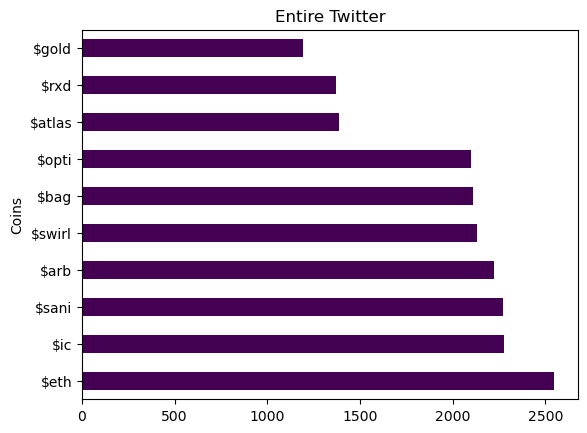

In [168]:
import seaborn as sns

# plot value_counts of Series
ax = df3['coin4'].value_counts().head(10).plot(kind='barh', 
                                               ylabel='Coins',
                                               title='Entire Twitter',
                                               cmap='viridis');

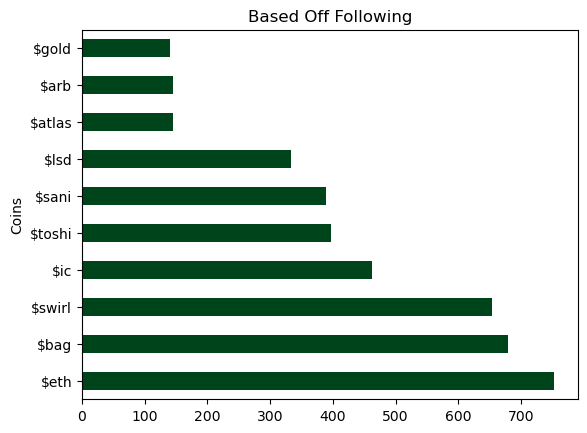

In [174]:
ax = df_following_coin['coin4'].value_counts().head(10).plot(kind='barh', 
                                               ylabel='Coins',
                                               title='Based Off Following',
                                               cmap='Greens_r');

In [135]:
df_following_coin['coin4'].value_counts().head(10)

$eth      753
$bag      680
$swirl    653
$ic       463
$toshi    397
$sani     389
$lsd      333
$atlas    146
$arb      145
$gold     140
Name: coin4, dtype: int64

# Create Databases for base bitcoin and eth

In [82]:
btc_sentiment = df3[['date', 'sentiment']].loc[df3['coin4'] == '$btc'].set_index('date').sort_values(by='date')
btc_sentiment = clean_sentiments(btc_sentiment)

In [83]:
eth_sentiment = df3[['date', 'sentiment']].loc[df3['coin4'] == '$eth'].set_index('date').sort_values(by='date')
eth_sentiment = clean_sentiments(eth_sentiment)

### Rolling AVG

In this case, no need to take rolling average! There is sufficient data for BTC and ETH.

### Pull Coin Data

In [84]:
btc = coin_data('bitcoin')
eth = coin_data('ethereum')

### Combine sentiment and price data

In [85]:
btc = btc.merge(btc_sentiment, left_index=True, right_index=True)
eth = eth.merge(eth_sentiment, left_index=True, right_index=True)

#### Create Target Column

In [88]:
btc = create_target(btc)
eth = create_target(eth)

In [89]:
btc

,open,high,low,close,sentiment,tomorrow,target
date,,,,,,,
2023-03-18,27445.304000,27516.324000,27356.310000,27429.616000,-0.020833,27673.546667,1
2023-03-19,27685.218333,27820.031667,27500.931667,27673.546667,0.260833,28133.746667,1
2023-03-20,28042.538333,28227.458333,27937.685000,28133.746667,0.090278,28158.811667,1
2023-03-21,28150.191667,28337.503333,28056.408333,28158.811667,0.075000,28107.591667,0
2023-03-22,28016.553333,28222.450000,27917.401667,28107.591667,0.050000,28050.140000,0
2023-03-23,28165.838333,28240.628333,27938.148333,28050.140000,0.282738,27962.461667,0
2023-03-24,28119.335000,28160.583333,27895.051667,27962.461667,0.650000,27698.843333,0
2023-03-25,27650.408333,27742.820000,27589.366667,27698.843333,0.257500,27887.713333,1
2023-03-26,27839.353333,27986.511667,27788.546667,27887.713333,0.245000,27422.450000,0


# Create Databases for 3 coins

### Sentiment Database per coin

In [90]:
top3_list = sentiment['coin'][:3].tolist()

In [91]:
coin1_sentiment = df3[['date', 'sentiment']].loc[df3['coin4'] == top3_list[0]].set_index('date').sort_values(by='date')

In [92]:
coin1_sentiment = clean_sentiments(coin1_sentiment)

In [93]:
coin2_sentiment = df3[['date', 'sentiment']].loc[df3['coin4'] == top3_list[1]].set_index('date').sort_values(by='date')

In [94]:
coin2_sentiment = clean_sentiments(coin2_sentiment)

In [95]:
coin3_sentiment = df3[['date', 'sentiment']].loc[df3['coin4'] == top3_list[2]].set_index('date').sort_values(by='date')

In [96]:
coin3_sentiment = clean_sentiments(coin3_sentiment)

In [97]:
coin3_sentiment

,sentiment
2023-03-18,0.000000
2023-03-19,0.600000
2023-03-20,0.000000
2023-03-21,0.000000
2023-03-22,0.000000
2023-03-23,0.000000
2023-03-24,0.000000
2023-03-25,0.000000
2023-03-26,0.000000
2023-03-27,0.000000


#### Rolling Average

In [98]:
rolling_edits1 = coin1_sentiment.rolling(3).mean()
rolling_edits1 = rolling_edits1.dropna()

In [99]:
rolling_edits2 = coin2_sentiment.rolling(3).mean()
rolling_edits2 = rolling_edits2.dropna()

In [100]:
rolling_edits3 = coin3_sentiment.rolling(3).mean()
rolling_edits3 = rolling_edits3.dropna()

#### Get Top 3 Coin Data

In [101]:
# Convert top 3 coins into full name and list
top3 = [sub[1:] for sub in sentiment['coin'][:3].tolist()]

In [102]:
coin_list = cg.get_coins_list()
d = {}
for coin in coin_list:
    d[coin['symbol']] = coin['id']

In [103]:
top3_fullname = []

for i, (k, v) in enumerate(d.items()):
    for x in top3:
        if x == k:
            top3_fullname.append(v)
        else:
            None

In [104]:
coin1 = coin_data(top3_fullname[0])
coin2 = coin_data(top3_fullname[1])
coin3 = coin_data(top3_fullname[2])

### Combine sentiment and price data

In [105]:
coin1 = coin1.merge(rolling_edits1, left_index=True, right_index=True)
coin2 = coin2.merge(rolling_edits2, left_index=True, right_index=True)
coin3 = coin3.merge(rolling_edits3, left_index=True, right_index=True)

In [106]:
coin1 = create_target(coin1)
coin2 = create_target(coin2)
coin3 = create_target(coin3)

#### Baseline Target

In [107]:
coin1['target'].value_counts(normalize=True)

0    0.551724
1    0.448276
Name: target, dtype: float64

<AxesSubplot:xlabel='date'>

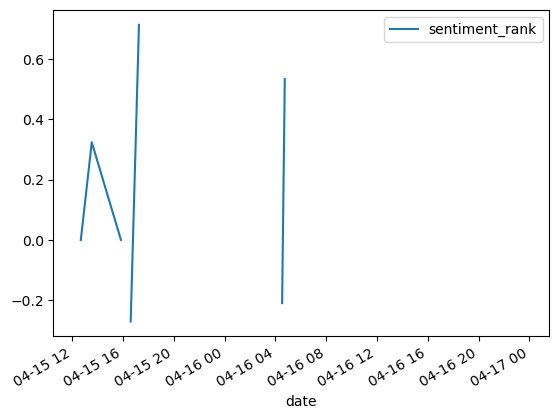

In [131]:
df3.loc[df3['coin4'] == '$algo'].plot(kind='line',x='date',y='sentiment_rank')

# TFID Vectorizer

C:\Users\tu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


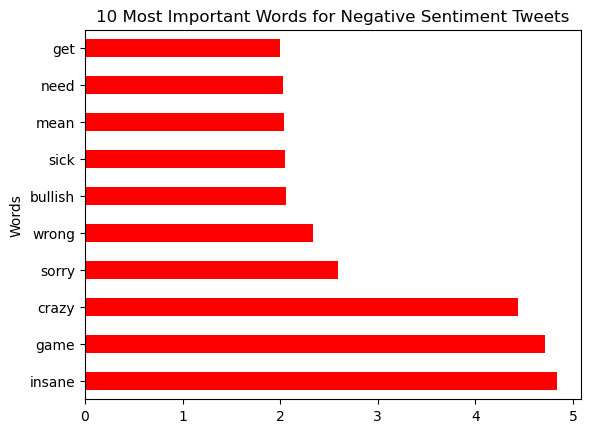

In [127]:
top_10_words(df_following_coin, 'neg');

C:\Users\tu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


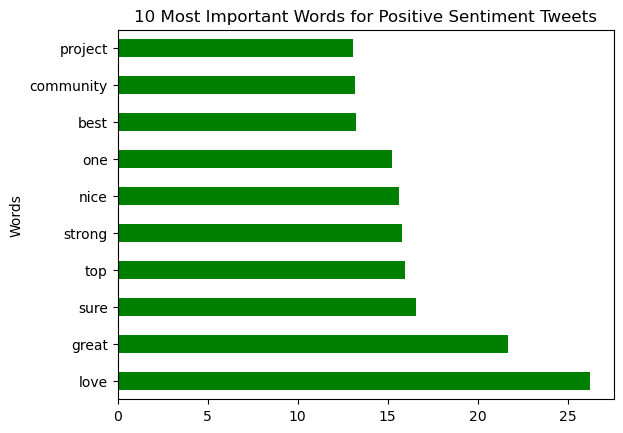

In [128]:
top_10_words(df_following_coin, 'pos');

C:\Users\tu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


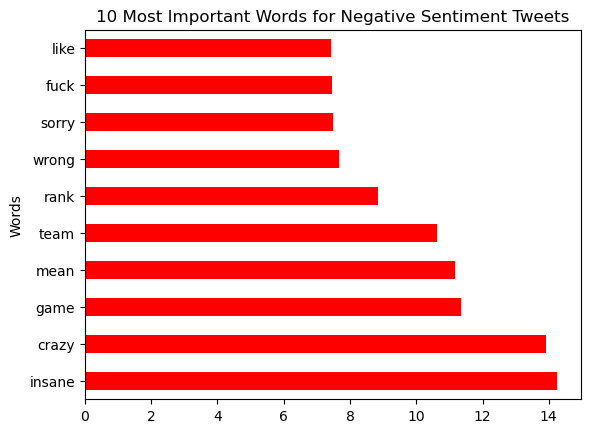

In [129]:
top_10_words(df3, 'neg');

C:\Users\tu\anaconda3\lib\site-packages\sklearn\utils\deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)


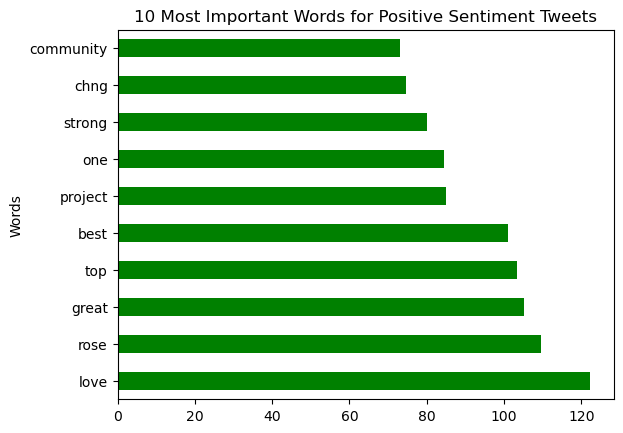

In [130]:
top_10_words(df3, 'pos');

## Saving Collected Data

> Export dataframes for EDA. Used Tableu.

In [ ]:
df_following_coin.to_csv('../data/tweets_following.csv', index = False)
df3.to_csv('../data/tweets_entire.csv', index = False)
sentiment.to_csv('../data/sentiment.csv', index = False)

> This data is being saved as `.csv` files to be later used in `02_Modeling` for modeling. 
- BTC
- ETH
- coin1
- coin2
- coin3

In [ ]:
btc.to_csv('../data/btc.csv')
eth.to_csv('../data/eth.csv')

In [ ]:
coin1.to_csv('../data/algo.csv', index = False)
coin2.to_csv('../data/pepe.csv', index = False)
coin3.to_csv('../data/finu.csv', index = False)

In [ ]:
for i in top3:
    print(i)

In [ ]:
for k, v in enumerate(top3):
    token = 'coin' + str(k + 1)
    token.to_csv('../data/'+ v + '.csv', index = False)

In [ ]:
pd.set_option('display.max_rows', 500)